In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraqm

In [ ]:
from IPython.display import clear_output
!sudo apt-get install libfreetype6-dev libharfbuzz-dev libfribidi-dev gtk-doc-tools
!git clone https://github.com/HOST-Oman/libraqm.git
clear_output()

In [ ]:
cd libraqm/

/content/libraqm


In [ ]:
!sudo apt-get install autoconf libtool autogen
!sudo /bin/bash autogen.sh 
!sudo /bin/bash configure
!sudo make
!sudo make install
!sudo make check
!sudo /sbin/ldconfig
clear_output()

In [ ]:
cd ..

/content


In [ ]:
!pip3 uninstall pillow -y
!pip3 install pillow>=7.1.0 --global-option="build_ext" --global-option="--enable-freetype"
clear_output()

## Make Sure These Two files are present

In [ ]:
class_map_csv='/content/drive/MyDrive/ApsisSolutions/demo_files/class_map.csv'
font_path='/content/drive/MyDrive/ApsisSolutions/demo_files/Bangla.ttf'
# font_path=['/content/drive/MyDrive/ApsisSolutions/demo_files/Bangla.ttf','/content/drive/MyDrive/ApsisSolutions/demo_files/Felipa-Regular']
# font_path='/content/drive/MyDrive/ApsisSolutions/demo_files/Felipa-Regular'

## Error Check

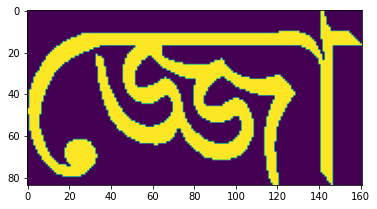

In [ ]:
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
import matplotlib.pyplot as plt
%matplotlib inline 
import os 
import cv2
import numpy as np


def stripPads(arr,val):
  '''
      strip specific values
  '''
  arr=arr[~np.all(arr == val, axis=1)]
  arr=arr[:, ~np.all(arr == val, axis=0)]
  return arr

def show_grapheme(char):
  HEIGHT = 256
  WIDTH = 256
  image = Image.new('RGB', (WIDTH, HEIGHT))
  draw = ImageDraw.Draw(image)
  myfont = ImageFont.truetype('/content/drive/MyDrive/ApsisSolutions/demo_files/Bangla.ttf', 128)
  w, h = draw.textsize(char, font=myfont)
  draw.text(((WIDTH - w) / 2,(HEIGHT - h) / 2), char, font=myfont)
  image=image.convert('L')

  image=np.array(image)
  image[image <= 128]=0
  image[image > 128]=255
  
  image=stripPads(image,0)
  plt.imshow(image)
  plt.show()
show_grapheme("জ্জো")

## Parser Class

In [ ]:
# -*-coding: utf-8 -
'''
    @author: Tahsin Reasat
    Adoptation:MD. Nazmuddoha Ansary
'''
#--------------------
# imports
#--------------------
import pandas as pd

#--------------------
# Parser class
#--------------------
class GraphemeParser():
    def __init__(self,class_map_csv):
        # gets class map
        self.class_map_csv=class_map_csv
        # initializes components
        self.__getComps()
    
    def __getComps(self):
        '''
            **Private Initialization**

            reads and creates dataframe for roots,consonant_diacritic,vowel_diacritic and graphemes 
            args:
                class_map_csv        : path of classes.csv
            returns:
                tuple(df_root,df_vd,df_cd)
                df_root          :     dataframe for grapheme roots
                df_vd            :     dataframe for vowel_diacritic 
                df_cd            :     dataframe for consonant_diacritic
                
        '''
        # read class map
        df_map=pd.read_csv(self.class_map_csv)
        # get grapheme roots
        df_root = df_map.groupby('component_type').get_group('grapheme_root')
        df_root.index = df_root['label']
        df_root = df_root.drop(columns = ['label','component_type'])
        # get vowel_diacritic
        df_vd = df_map.groupby('component_type').get_group('vowel_diacritic')
        df_vd.index = df_vd['label']
        df_vd = df_vd.drop(columns = ['label','component_type'])
        # get consonant_diacritic
        df_cd = df_map.groupby('component_type').get_group('consonant_diacritic')
        df_cd.index = df_cd['label']
        df_cd = df_cd.drop(columns = ['label','component_type'])
        
        self.vds    =df_vd.component.tolist()
        self.cds    =df_cd.component.tolist()
        self.roots  =df_root.component.tolist()

        

    def word2grapheme(self,word):
        graphemes = []
        grapheme = ''
        i = 0
        while i < len(word):
            grapheme += (word[i])
            # print(word[i], grapheme, graphemes)
            # deciding if the grapheme has ended
            if word[i] in ['\u200d', '্']:
                # these denote the grapheme is contnuing
                pass
            elif word[i] == 'ঁ':  
                # 'ঁ' always stays at the end
                graphemes.append(grapheme)
                grapheme = ''
            elif word[i] in list(self.roots) + ['়']:
                # root is generally followed by the diacritics
                # if there are trailing diacritics, don't end it
                if i + 1 == len(word):
                    graphemes.append(grapheme)
                elif word[i + 1] not in ['্', '\u200d', 'ঁ', '়'] + list(self.vds):
                    # if there are no trailing diacritics end it
                    graphemes.append(grapheme)
                    grapheme = ''

            elif word[i] in self.vds:
                # if the current character is a vowel diacritic
                # end it if there's no trailing 'ঁ' + diacritics
                # Note: vowel diacritics are always placed after consonants
                if i + 1 == len(word):
                    graphemes.append(grapheme)
                elif word[i + 1] not in ['ঁ'] + list(self.vds):
                    graphemes.append(grapheme)
                    grapheme = ''

            i = i + 1
            # Note: df_cd's are constructed by df_root + '্'
            # so, df_cd is not used in the code

        return graphemes

    

## Font Based Lines

In [ ]:
from pprint import pprint

head_names=[
               "এ.স. এন্টারপ্রাইজ",
               "ড্রিস্ট্রিবিউটরঃ এম/এস হাশেম ট্রেডিং",
               "হাউস নাম্বারঃ ১২৩৪, বাড্ডা, গুলশান, ঢাকা।",    
               "মোবাইল নাম্বারঃ ০১৭২৩৪৫৬৭৮৯",
               "নাম্বারঃ",
               "তারিখঃ"
               ] 

head_var_names=[
                
               "আউটলেটের নামঃ",
               "রাউটঃ",
               "ঠিকানাঃ"
                
                ]


#  "হউস নংঃ ১২৩৪/০৯, বাড্ডা, গুলশান, ঢাকা।",    
              #  "মোবাইল নংঃ ০১৭২৩৪৫৬৭৮৯",

# product_names=["ছোট করে লেখা",
#                "র‍্যান্ডম প্রোডাক্ট নাম্বার ১",
#                "র‍্যান্ডম বিড়ি",
#                "আরো কিছু",
#                "৪২০ মার্কা বিড়ি",
#                "রং নাম্বার"] 


# start of marking value
iden=2
# global
font_size=128
bangla_num=["০","১","২","৩","৪","৫","৬","৭","৮","৯"]
gp=GraphemeParser(class_map_csv)


# # process productnames
# data=[]
# for p in product_names:
#   words=p.split()
#   _data=[]
#   # add space after a word
#   for word in words:
#     # _data.append(word)   ### <<<<===
#     if any(char in bangla_num for char in word):
#       graphemes=[g for g in word]
#     else:
#       graphemes=gp.word2grapheme(word)
#     graphemes.append(" ")
#     _data+=graphemes
#   data.append(_data)


# pprint(data)

import regex
data=[]

for p in head_names:
  if p == head_names[-1]:
    # print(p)
    head_names[-1] = head_names[-1]+ 35*(".")
    p = head_names[-1]
  # print(head_names[-1])

  _data=[]
  rem_str=p
  # find pure bangla words and numbers
  words=regex.findall(r"[^\x20-\x2F\x3A-\x40\x5B-\x60\x7B-\x7E\x7C]+",p)
  for idx,word in enumerate(words):
     
    comps=[]
    # find previous strings
    prev_str=rem_str.partition(word)[0]
    # get remainder string
    rem_str="".join(list(rem_str.partition(word)[2:]))
    
    if prev_str.strip():
      comps+=[c for c in prev_str]
    # _data.append(word)   ### <<<<===
    if any(char in bangla_num for char in word):
      comps+=[g for g in word]
      
    else:
      comps+=gp.word2grapheme(word)
    
    # for last word
    if idx==len(words)-1:
      comps+=[c for c in rem_str]

    comps.append(" ")
    _data+=comps
  print(_data)  
  print(len(_data))
    
  data.append(_data)

# pprint(data)


['এ', ' ', '.', 'স', ' ', '.', ' ', 'এ', 'ন্টা', 'র', 'প্রা', 'ই', 'জ', ' ']
14
['ড্রি', 'স্ট্রি', 'বি', 'উ', 'ট', 'র', 'ঃ', ' ', 'এ', 'ম', ' ', '/', 'এ', 'স', ' ', 'হা', 'শে', 'ম', ' ', 'ট্রে', 'ডি', 'ং', ' ']
23
['হা', 'উ', 'স', ' ', 'না', 'ম্বা', 'র', 'ঃ', ' ', '১', '২', '৩', '৪', ' ', ',', ' ', 'বা', 'ড্ডা', ' ', ',', ' ', 'গু', 'ল', 'শা', 'ন', ' ', ',', ' ', 'ঢা', 'কা', ' ']
31
['মো', 'বা', 'ই', 'ল', ' ', 'না', 'ম্বা', 'র', 'ঃ', ' ', '০', '১', '৭', '২', '৩', '৪', '৫', '৬', '৭', '৮', '৯', ' ']
22
['না', 'ম্বা', 'র', 'ঃ', ' ']
5
['তা', 'রি', 'খ', 'ঃ', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', ' ']
40


In [ ]:
head_var_names=[
                
               "আউটলেটের নামঃ",
               "রাউটঃ",
               "ঠিকানাঃ"
                
                ]

for i, p in enumerate(head_var_names):
  dot_len = 65-len(p)
  head_var_names[i] = head_var_names[i]+dot_len*(".")
  p = head_var_names[i]

  _data=[]
  rem_str=p
  # find pure bangla words and numbers
  words=regex.findall(r"[^\x20-\x2F\x3A-\x40\x5B-\x60\x7B-\x7E\x7C]+",p)
  for idx,word in enumerate(words):
     
    comps=[]
    # find previous strings
    prev_str=rem_str.partition(word)[0]
    # get remainder string
    rem_str="".join(list(rem_str.partition(word)[2:]))
    
    if prev_str.strip():
      comps+=[c for c in prev_str]
    # _data.append(word)   ### <<<<===
    if any(char in bangla_num for char in word):
      comps+=[g for g in word]
      
    else:
      comps+=gp.word2grapheme(word)
    
    # for last word
    if idx==len(words)-1:
      comps+=[c for c in rem_str]

    comps.append(" ")
    _data+=comps
  print(_data)  
  print(len(_data))
    
  data.append(_data)

['আ', 'উ', 'ট', 'লে', 'টে', 'র', ' ', 'না', 'ম', 'ঃ', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', ' ']
63
['রা', 'উ', 'ট', 'ঃ', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', ' ']
65
['ঠি', 'কা', 'না', 'ঃ', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', ' ']
63


In [ ]:
a = ["তারিখঃ"]

if a[-1]:
  a[-1] = a[-1]+ 35*(".")

print(a)

['তারিখঃ...................................']


## Draw Text

13
29
50
68
71
109
169
232
293


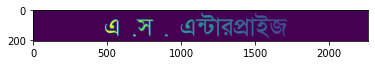

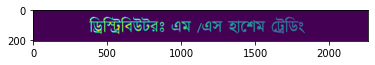

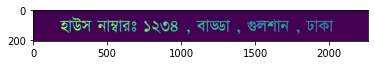

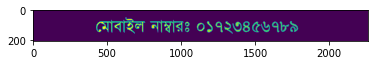

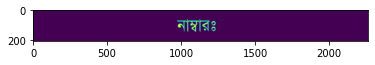

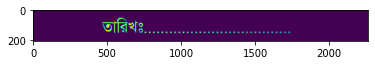

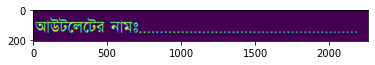

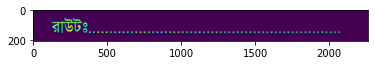

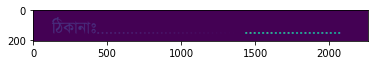

[{3: 'এ', 4: '.', 5: 'স', 6: '.', 7: 'এ', 8: 'ন্টা', 9: 'র', 10: 'প্রা', 11: 'ই', 12: 'জ'}, {13: 'ড্রি', 14: 'স্ট্রি', 15: 'বি', 16: 'উ', 17: 'ট', 18: 'রঃ', 19: 'এ', 20: 'ম', 21: '/', 22: 'এ', 23: 'স', 24: 'হা', 25: 'শে', 26: 'ম', 27: 'ট্রে', 28: 'ডিং'}, {29: 'হা', 30: 'উ', 31: 'স', 32: 'না', 33: 'ম্বা', 34: 'রঃ', 35: '১', 36: '২', 37: '৩', 38: '৪', 39: ',', 40: 'বা', 41: 'ড্ডা', 42: ',', 43: 'গু', 44: 'ল', 45: 'শা', 46: 'ন', 47: ',', 48: 'ঢা', 49: 'কা'}, {50: 'মো', 51: 'বা', 52: 'ই', 53: 'ল', 54: 'না', 55: 'ম্বা', 56: 'রঃ', 57: '০', 58: '১', 59: '৭', 60: '২', 61: '৩', 62: '৪', 63: '৫', 64: '৬', 65: '৭', 66: '৮', 67: '৯'}, {68: 'না', 69: 'ম্বা', 70: 'রঃ'}, {71: 'তা', 72: 'রি', 73: 'খঃ', 74: '.', 75: '.', 76: '.', 77: '.', 78: '.', 79: '.', 80: '.', 81: '.', 82: '.', 83: '.', 84: '.', 85: '.', 86: '.', 87: '.', 88: '.', 89: '.', 90: '.', 91: '.', 92: '.', 93: '.', 94: '.', 95: '.', 96: '.', 97: '.', 98: '.', 99: '.', 100: '.', 101: '.', 102: '.', 103: '.', 104: '.', 105: '.', 106: '.', 

In [ ]:
iden=3

def createPrintedLine(iden,
                       comps,
                       font_path,
                       font_size):
    '''
        creates printed word image
        args:
            iden    :       identifier marking value starting
            comps   :       the list of components
            font_path:      the desired font path 
            font_size:      the size of the font
        returns:
            img     :       marked word image
            label   :       dictionary of label {iden:label}
            iden    :       the final identifier
    '''
    val_offset=iden
    comps=[str(comp) for comp in comps]
    # max dim
    min_offset=100
    max_dim=len(comps)*font_size+min_offset
    # reconfigure comps
    mods=['ঁ', 'ং', 'ঃ']
    for idx,comp in enumerate(comps):
        if idx < len(comps)-1 and comps[idx+1] in mods:
            comps[idx]+=comps[idx+1]
            comps[idx+1]=None 
            
    comps=[comp for comp in comps if comp is not None]
    word="".join(comps)
    # font path
    font=ImageFont.truetype(font_path, size=font_size)
    # sizes of comps
    (comp_size,_),(_,_) = font.font.getsize(word)  
    # construct labels
    label={}
    imgs=[]
    x=0
    y=0
    comp_str=''
    for comp in comps:
        comp_str+=comp
        # # calculate increment
        # (comp_width,_),(offset,_)=comp_size
        # dx = comp_width+offset 
        # draw
        image = Image.new(mode='L', size=(max_dim,max_dim))
        draw = ImageDraw.Draw(image)
        #draw.text(xy=(x, y), text=comp, fill=iden, font=font)
        draw.text(xy=(0, 0), text=comp_str, fill=1, font=font)
        
        imgs.append(np.array(image))
        
        # x+=dx
        # label
        if comp!=' ':
          label[iden] = comp 
          iden+=1
          
        
    # add images
    img=sum(imgs)
    #img=stripPads(img,0)
    img=img[~np.all(img == 0, axis=1)]
    img=img[:,:comp_size]
    img[img>0]+=val_offset-1
    return img,label,iden

imgs=[]
labels=[]
h_max,w_max=0,0
# find images and labels
i = 0
for line in data: 
  i += 1
  if i == 1:
    img,label,iden=createPrintedLine(iden,
                                    line,
                                    font_path,
                                    200)
  else:
    img,label,iden=createPrintedLine(iden,
                                    line,
                                    font_path,
                                    font_size)
  print(iden)
  h,w=img.shape
  if h>h_max:
    h_max=h
  if w>w_max:
    w_max=w

  imgs.append(img)
  labels.append(label)

h_max+=32
w_max+=32

def padImg(line_img):
  # shape
  h,w=line_img.shape
  # pad widths
  left_pad_width = (w_max-w) // 2 # <<<<<<<<==========
  right_pad_width=  w_max-w-left_pad_width  # <<<<<<<<==========
  # pads
  left_pad =np.zeros((h,left_pad_width))
  right_pad=np.zeros((h,right_pad_width))
  # pad
  line_img =np.concatenate([left_pad,line_img,right_pad],axis=1)
  
  # shape
  h,w=line_img.shape
  # pad heights
  top_pad_height =(h_max-h)//2
  bot_pad_height=h_max-h-top_pad_height
  # pads
  top_pad =np.zeros((top_pad_height,w))
  bot_pad=np.zeros((bot_pad_height,w))
  # pad
  line_img =np.concatenate([top_pad,line_img,bot_pad],axis=0)
  return line_img

padded=[]
for img in imgs:
  img=padImg(img)
  padded.append(img)
  # back=np.zeros(img.shape)
  # back[img==3]=255
  # plt.imshow(back)
  # plt.show()
  plt.imshow(padImg(img))
  plt.show()
  
print(labels)

In [ ]:
print(len("তারিখঃ"))
print(len("আউটলেটের নামঃ"))
print(len("রাউটঃ"))
print(len("ঠিকানাঃ"))

6
13
5
7


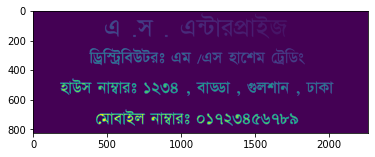

[ 0.  4.  5.  6.  7.  8.  9. 11. 13. 14. 15. 16. 17. 18. 19. 21. 22. 23.
 25. 26. 28. 29. 30. 31. 32. 33. 35. 36. 37. 38. 40. 42. 43. 45. 47. 48.
 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 63. 64. 65. 67. 68.
 69. 70.]


In [ ]:
_img=np.concatenate(padded[:4],axis=0)
plt.imshow(_img)
plt.show()
print(np.unique(_img))

In [ ]:
_img.shape

(824, 2263)

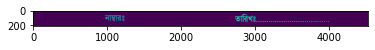

[  0.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.]


In [ ]:
_img_2 = np.concatenate(padded[4:6], axis=1)
plt.imshow(_img_2)
plt.show()
print(np.unique(_img_2))

In [ ]:
_img_2.shape

(206, 4526)

In [ ]:
h= _img_2.shape[0]
w= _img.shape[1]
dim = (h, w)
dim

(206, 2263)

In [ ]:
# dim = _img.shape
# dim[::-1]

In [ ]:
from PIL import Image
# _img_2 = _img_2.resize((h,w), Image.ANTIALIAS)
_img_2_resized = cv2.resize(_img_2, dim[::-1], interpolation = cv2.INTER_AREA)

In [ ]:
_img_2_resized.shape

(206, 2263)

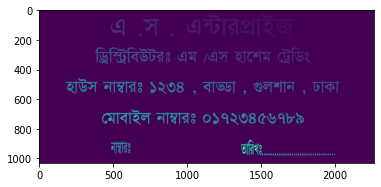

[  0.    4.    5.    6.    7.    8.    9.   11.   13.   14.   15.   16.
  17.   18.   19.   21.   22.   23.   25.   26.   28.   29.   30.   31.
  32.   33.   34.5  35.   35.5  36.   36.5  37.   37.5  38.   38.5  39.
  39.5  40.   40.5  41.   41.5  42.   42.5  43.   43.5  44.   44.5  45.
  45.5  46.   46.5  47.   47.5  48.   48.5  49.   49.5  50.   50.5  51.
  51.5  52.   52.5  53.   53.5  54.   54.5  55.   56.   57.   58.   59.
  60.   61.   63.   64.   65.   67.   68.   69.   69.5  70.   70.5  71.
  72.   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.
  84.   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.
  96.   97.   98.   99.  100.  101.  102.  103.  104.  105.  106.  107.
 108.  108.5 109. ]


In [ ]:
_img_3 = np.concatenate([_img, _img_2_resized], axis=0)
plt.imshow(_img_3)
plt.show()
print(np.unique(_img_3))

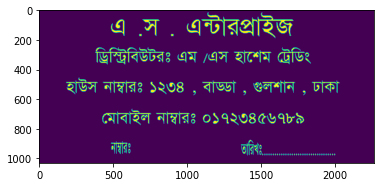

In [ ]:
_img_3[_img_3>0]=255
plt.imshow(_img_3)
plt.show()

In [ ]:
# head_var_names=[
                
#                "আউটলেটের নামঃ",
#                "রাউটঃ",
#                "ঠিকানাঃ"
                
#                 ]



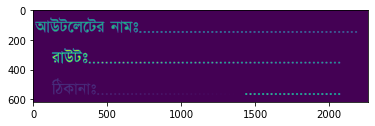

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37. 110. 111. 112. 113.
 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127.
 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141.
 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155.
 156. 157. 158. 159. 160. 161. 162. 163. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226.
 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240.
 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254.
 255.]


In [ ]:
im__ = np.concatenate(padded[6:], axis=0)
plt.imshow(im__)
plt.show()
print(np.unique(im__))

In [ ]:
im__.shape

(618, 2263)

In [ ]:
_img_3.shape

(1030, 2263)

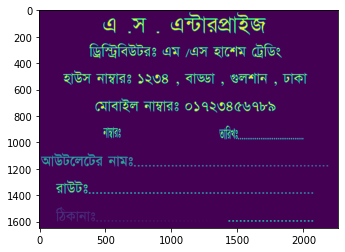

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37. 110. 111. 112. 113.
 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127.
 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141.
 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155.
 156. 157. 158. 159. 160. 161. 162. 163. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226.
 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240.
 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254.
 255.]


In [ ]:
img_4 = np.concatenate([_img_3, im__], axis=0)
plt.imshow(img_4)
plt.show()
print(np.unique(img_4))

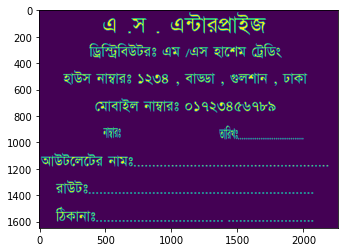

In [ ]:
img_4[img_4>0]=255
plt.imshow(img_4)
plt.show()

In [ ]:
# extra=np.zeros(_img.shape)
# extra[_img==5]=255
# plt.imshow(extra)
# plt.show()

In [ ]:
# __img=np.concatenate([_img,extra], axis=0)
# plt.imshow(__img)
# plt.show()
# print(np.unique(__img))

## Clear View

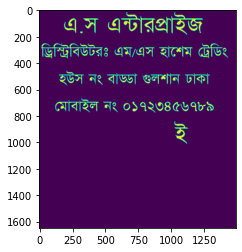

In [ ]:
__img[__img>0]=255
plt.imshow(__img)
plt.show()